In [19]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from joblib import dump

In [20]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [22]:
# Удаляем ненужные признаки, one hot encoding
df_train = df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace=True)

object_df = df_train.select_dtypes(include='object')
numeric_df = df_train.select_dtypes(exclude='object')

object_df = pd.get_dummies(object_df, drop_first=True)

new_df_train = pd.concat([object_df, numeric_df], axis=1)
new_df_train

/var/folders/m8/z1y71lq56bqcdc6jcv3cl3dw0000gn/T/ipykernel_47379/3177527326.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
/var/folders/m8/z1y71lq56bqcdc6jcv3cl3dw0000gn/T/ipykernel_47379/3177527326.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

,Embarked_Q,Embarked_S,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,False,True,0,3,0,22.0,1,0,7.2500
1,False,False,1,1,1,38.0,1,0,71.2833
2,False,True,1,3,1,26.0,0,0,7.9250
3,False,True,1,1,1,35.0,1,0,53.1000
4,False,True,0,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...,...
886,False,True,0,2,0,27.0,0,0,13.0000
887,False,True,1,1,1,19.0,0,0,30.0000
888,False,True,0,3,1,28.0,1,2,23.4500
889,False,False,1,1,0,26.0,0,0,30.0000


In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB


In [24]:
X = new_df_train.drop('Survived', axis=1)
y = new_df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=101,
    shuffle=True
)

In [25]:
# Настройка гиперпараметров
params = {
    'max_depth': list(range(3, 15)),
    'min_samples_split': [2, 4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}
tree_model = DecisionTreeClassifier()
grid = GridSearchCV(
    estimator=tree_model,
    param_grid=params,
    cv=5,
    scoring='accuracy'
)
grid.fit(X_train, y_train)
print("Лучшие параметры:", grid.best_params_)
print("Лучшая accuracy:", grid.best_score_)

# Используем лучшую модель
best_model = grid.best_estimator_

Лучшие параметры: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Лучшая accuracy: 0.8250709677419354


In [26]:
# Обучаем модель с лучшими гиперпараметрами
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [27]:
# Смотрим точность
y_predict = best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_predict):.2f}")

Accuracy: 0.79


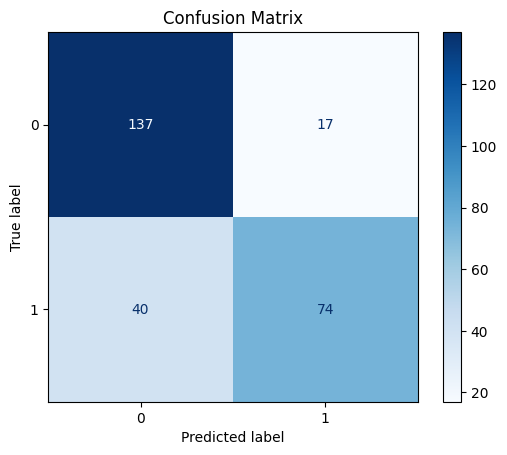

In [28]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [29]:
# Ключевые метрики
print(classification_report(y_test, y_predict, target_names=['Погиб', 'Выжил']))

              precision    recall  f1-score   support

       Погиб       0.77      0.89      0.83       154
       Выжил       0.81      0.65      0.72       114

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.77       268
weighted avg       0.79      0.79      0.78       268



In [30]:
# Кросс валидация
scores = cross_val_score(tree_model, X, y, cv=5)
print("Accuracy на каждом фолде:", scores)
print("Средняя accuracy:", scores.mean())

Accuracy на каждом фолде: [0.72625698 0.79213483 0.80337079 0.73595506 0.83146067]
Средняя accuracy: 0.777835666310966


In [31]:
final_model = grid.best_estimator_
final_model.fit(X, y)

dump(final_model, 'final_model.joblib')

['final_model.joblib']